# iSens Lab: Step-CW Radar Data Processing (Sean Yao)

### 1. Import Necessary Librarys

In [1]:
# import librarys
import numpy as np
from scipy import constants
import scipy.signal as ss
from matplotlib import pyplot as plt
from math import ceil, log
import cv2
import math
from scipy.spatial import distance
from collections import deque
from pyargus.directionEstimation import *
from pyargus.antennaArrayPattern import array_rad_pattern_plot
from pyargus.tests.patternPlotTest import demo_ULA_plot
from vtrigU_helper_functions import *
# matplotlib.use('TkAgg')

# define constants
c = constants.c # speed of light
antsLocations = ants_locations()

### 2. Load Parameters

In [2]:
# Compute necessary values
BW = 7e9
Rres = c/(2*BW)
Rmax = 75*c/BW
print('Current Radar Setup:')
print(f"Range Resolution = {Rres} m")
print(f"Maximum Range = {Rmax} m")

Current Radar Setup:
Range Resolution = 0.021413747 m
Maximum Range = 3.21206205 m


In [3]:
# load setup parameters
freq = np.load('./constants/freq.npy')
nframes = np.load('./constants/nframes.npy')
TxRxPairs = np.load('./constants/TxRxPairs.npy')

Nfft = 2**(ceil(log(freq.shape[0],2))+1)
Ts = 1/Nfft/(freq[1]-freq[0]+1e-16) # Avoid nan checks
time_vec = np.linspace(0,Ts*(Nfft-1),num=Nfft)
dist_vec = time_vec*(c/2) # distance in meters
N_freq = freq.shape[0]


print(f'Freq Points: {freq.shape[0]} ')
print(f'TxRxPairs Shape: {TxRxPairs.shape}')
print(f'Nfft = {Nfft}')
print(f'Number of Recorded Frames: {nframes}')

Freq Points: 150 
TxRxPairs Shape: (400, 2)
Nfft = 512
Number of Recorded Frames: 100


### 3. Load Data

In [4]:
# specify data path components
scenario = 'test/'
data_path = './data/' + scenario
raw_data = 'move_z/recording.npy'
cal_data = 'move_z/calibration.npy'

# combine data paths
raw_path = data_path + raw_data
cal_path = data_path + cal_data
# processed_path = data_path + processed_data

# load data
print('Scenario: move in z direction')
print('')
z_recArr = np.load(raw_path)
z_calArr = np.load(cal_path)
print(f'z_calArr Shape: {z_calArr.shape}')
print(f'z_recArr Shape: {z_recArr.shape}')
print('')

# specify data path components
scenario = 'test/'
data_path = './data/' + scenario
raw_data = 'move_x/recording.npy'
cal_data = 'move_x/calibration.npy'

# combine data paths
raw_path = data_path + raw_data
cal_path = data_path + cal_data
# processed_path = data_path + processed_data

# load data
print('Scenario: move in x direction')
print('')
x_recArr = np.load(raw_path)
x_calArr = np.load(cal_path)
print(f'x_calArr Shape: {x_calArr.shape}')
print(f'x_recArr Shape: {x_recArr.shape}')
print('')

# specify data path components
scenario = 'test/'
data_path = './data/' + scenario
raw_data = 'move_y/recording.npy'
cal_data = 'move_y/calibration.npy'

# combine data paths
raw_path = data_path + raw_data
cal_path = data_path + cal_data
# processed_path = data_path + processed_data

# load data
print('Scenario: move in y direction')
print('')
y_recArr = np.load(raw_path)
y_calArr = np.load(cal_path)
print(f'y_calArr Shape: {y_calArr.shape}')
print(f'y_recArr Shape: {y_recArr.shape}')
print('')
print('recArr Channels: (frame, Tx*Rx, freqs)')



Scenario: move in z direction

z_calArr Shape: (10, 400, 150)
z_recArr Shape: (100, 400, 150)

Scenario: move in x direction

x_calArr Shape: (10, 400, 150)
x_recArr Shape: (100, 400, 150)

Scenario: move in y direction

y_calArr Shape: (10, 400, 150)
y_recArr Shape: (100, 400, 150)

recArr Channels: (frame, Tx*Rx, freqs)


### 5. Time of Flight

In [5]:
def normalization(x):
    return (x - np.min(x))/(np.max(x)-np.min(x))

def compute_tof(X, Nfft=512):
    x = np.fft.ifft(X,Nfft,1)
    return np.linalg.norm(x,axis=0)

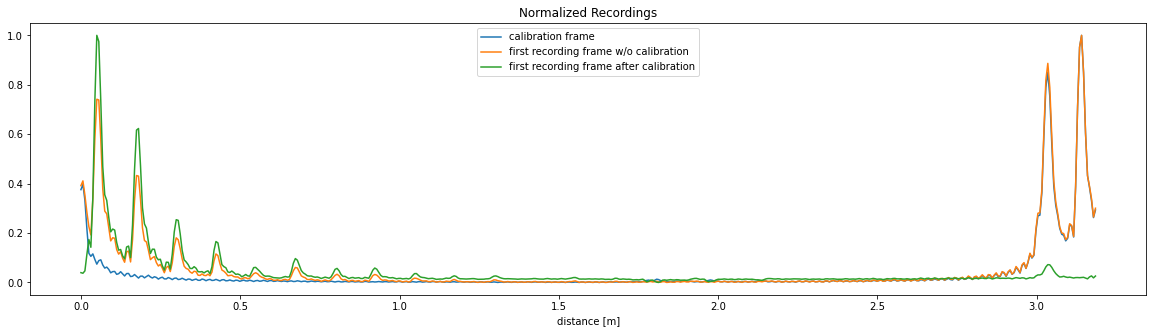

In [6]:
calArr = z_calArr
recArr = z_recArr
# plot the calibration frame
plt.figure(figsize=(20,5))
calArr_tof = []
for i in range(len(calArr)):
    X = calArr[i,:,:]
    x = compute_tof(X, Nfft)
    calArr_tof.append(x)
calArr_tof = np.mean(calArr_tof,axis=0)

# plot the first frame of recording without calibration
X = recArr[0,:,:]
x = compute_tof(X, Nfft)

plt.plot(dist_vec, normalization(calArr_tof));
plt.plot(dist_vec, normalization(x));
plt.plot(dist_vec, normalization(x-calArr_tof));
plt.title('Normalized Recordings')
plt.xlabel('distance [m]');
plt.legend(['calibration frame', 'first recording frame w/o calibration', 'first recording frame after calibration'])

In [7]:
# Process the recording with calibration
proArr = recArr - np.mean(calArr,axis=0)
proArr = proArr.reshape(100,20,20,-1)
print(proArr.shape)

(100, 20, 20, 150)


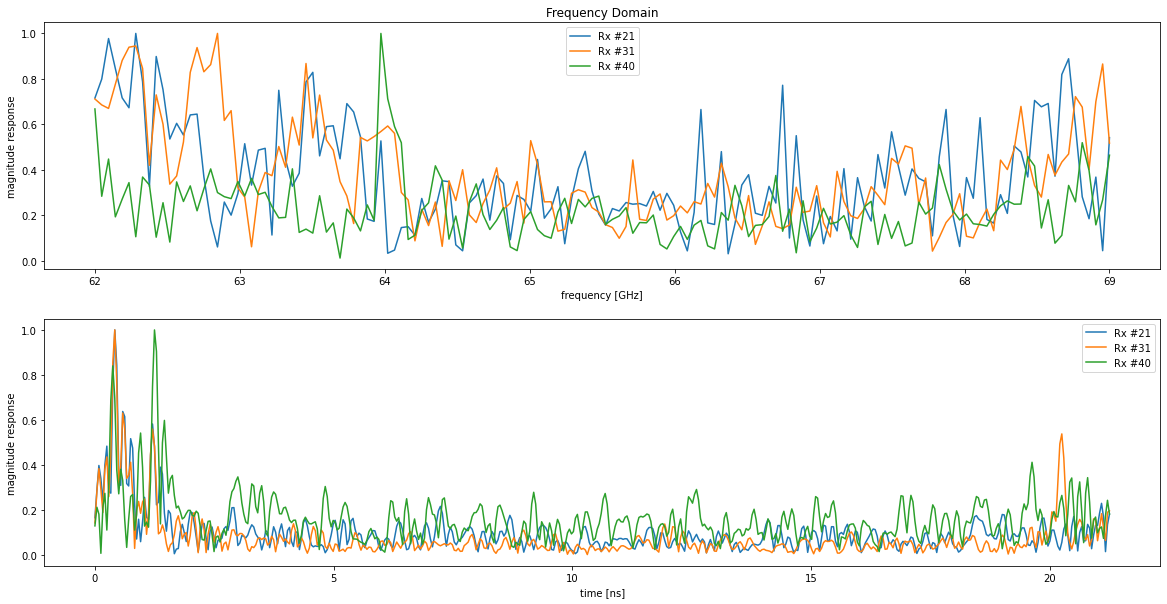

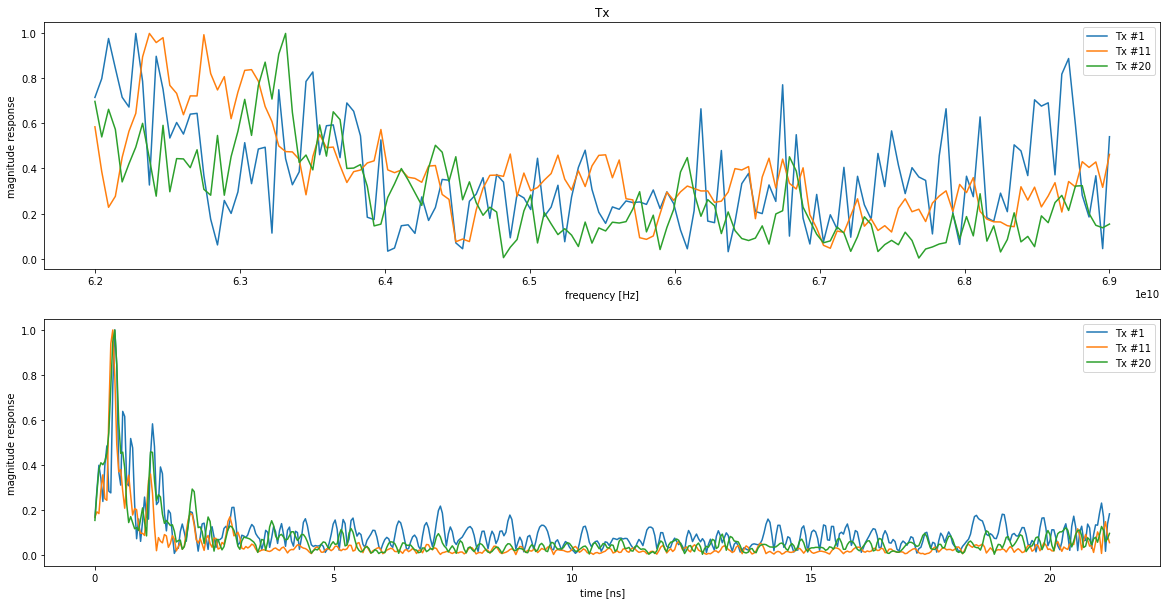

In [8]:
n_rx = 20
n_tx = 20
proArr_ifft = np.fft.ifft(proArr,axis=-1,n=Nfft)
proArr_ifft = np.divide(np.abs(proArr_ifft),np.max(np.abs(proArr_ifft)))

plt.figure(figsize=(20,10))
plt.subplot(211)
for i in [0,10,19]:
    plt.plot(freq*10**-9, np.divide(np.abs(proArr[0,0,i,:]),np.max(np.abs(proArr[0,0,i,:]))))
plt.title('Frequency Domain')
plt.xlabel('frequency [GHz]')
plt.ylabel('magnitude response')
plt.legend(['Rx #21', 'Rx #31', 'Rx #40'])
plt.subplot(212)
for i in [0,10,19]:
    plt.plot(time_vec*10**9, np.divide(np.abs(proArr_ifft[0,0,i,:]),np.max(np.abs(proArr_ifft[0,0,i,:]))))
# plt.title('Time Domain')
plt.xlabel('time [ns]')
plt.ylabel('magnitude response')
plt.legend(['Rx #21', 'Rx #31', 'Rx #40'])

plt.figure(figsize=(20,10))
plt.subplot(211)
for i in [0,10,19]:
    plt.plot(freq, np.divide(np.abs(proArr[0,i,0,:]),np.max(np.abs(proArr[0,i,0,:]))))
plt.title('Tx')
plt.xlabel('frequency [Hz]')
plt.ylabel('magnitude response')
plt.legend(['Tx #1', 'Tx #11', 'Tx #20'])
plt.subplot(212)
for i in [0,10,19]:
    plt.plot(time_vec*10**9, np.divide(np.abs(proArr_ifft[0,i,0,:]),np.max(np.abs(proArr_ifft[0,i,0,:]))))
# plt.title('Time Domain')
plt.xlabel('time [ns]')
plt.ylabel('magnitude response')
plt.legend(['Tx #1', 'Tx #11', 'Tx #20'])

(0.0, 3.184416552566554)

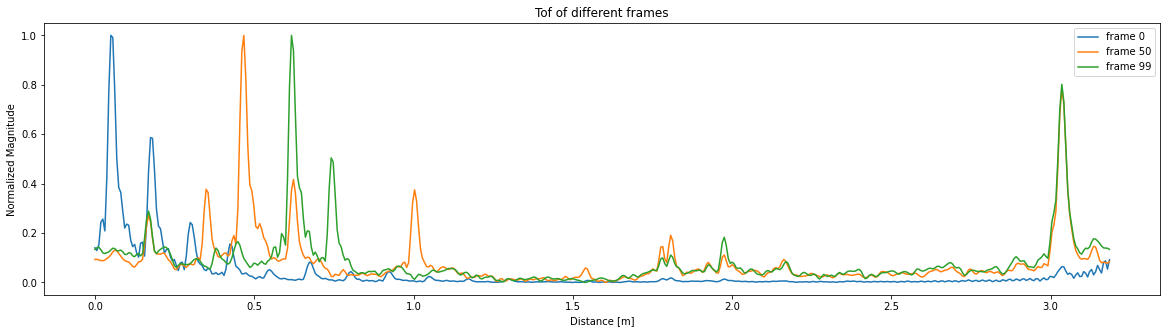

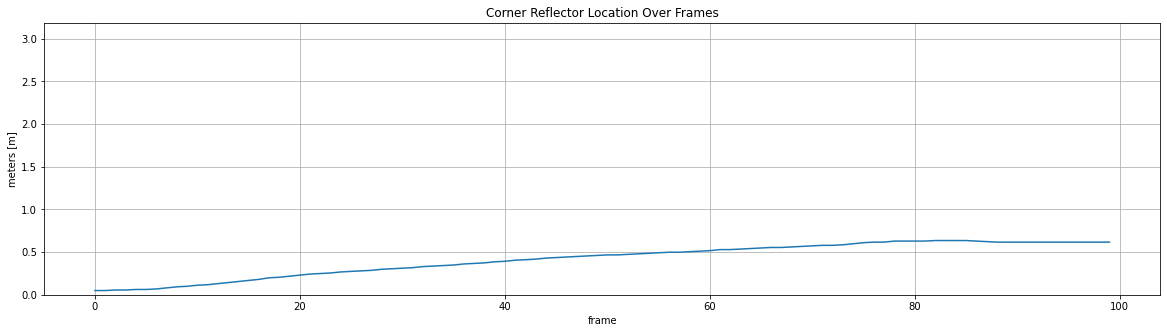

In [9]:
# plot three frames
plt.figure(figsize=(20,5))
for i in [0,50,99]:
    X = recArr[i,:,:]-np.mean(calArr,axis=0)
    x = compute_tof(X, Nfft)
    plt.plot(dist_vec, normalization(x));
plt.xlabel('Distance [m]');
plt.ylabel('Normalized Magnitude')
plt.legend(['frame 0','frame 50','frame 99']);
plt.title('Tof of different frames');

z_locations = []
for i in range(len(recArr)):
    cur_tof = compute_tof(recArr[i,:,:]-np.mean(calArr,axis=0))
    cur_tof[np.where(dist_vec>2.8)] = np.min(cur_tof) # eliminate the ceiling
    location = np.argmax(normalization(cur_tof))
    z_locations.append(location)
plt.figure(figsize=(20,5))
plt.plot(dist_vec[z_locations])
plt.xlabel('frame')
plt.ylabel('meters [m]')
plt.title('Corner Reflector Location Over Frames')
plt.grid()
plt.ylim(dist_vec[0],dist_vec[-1])

In [10]:
proArr_ifft = np.fft.ifft(proArr,axis=-1,n=Nfft)
proArr_ifft = np.divide(np.abs(proArr_ifft),np.max(np.abs(proArr_ifft)))

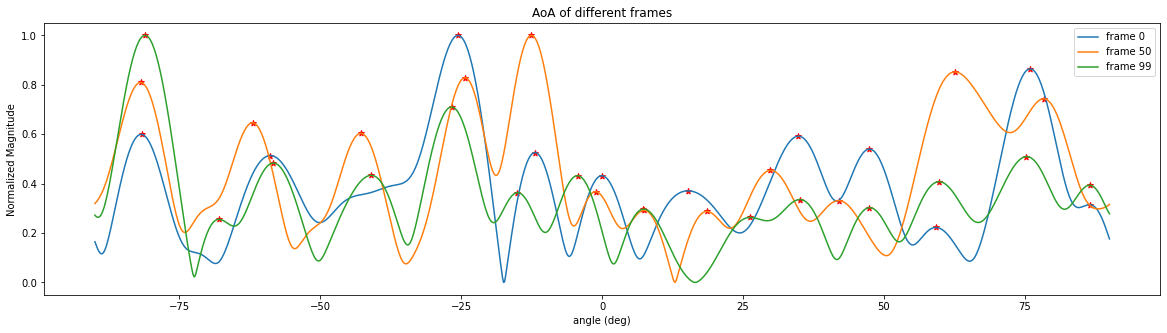

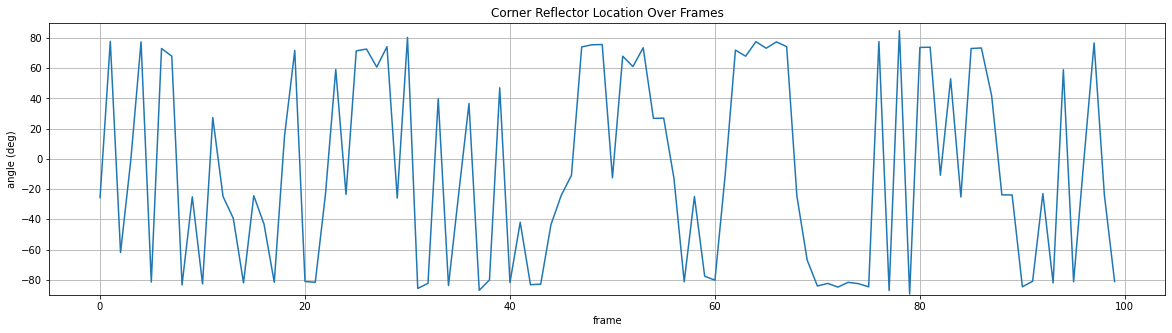

In [11]:
from scipy.signal import find_peaks

def normalization(x):
    return (x - np.min(x))/(np.max(x)-np.min(x))

def compute_aoa(X, Nfft=512):
    x = np.fft.ifft(X,Nfft,0)
    # return np.linalg.norm(x,axis=1)
    return np.abs(x[:,0])

calArr = y_calArr
recArr = y_recArr
Nfft_aoa = 2**(ceil(log(400,2))+1)
# plot three frames
plt.figure(figsize=(20,5))
angles = np.linspace(-90,90,Nfft_aoa)
for i in [0,50,99]:
    X = recArr[i,:,:]-np.mean(calArr,axis=0)
    X = X.reshape(20,20,-1)[0,:,:]
    x = compute_aoa(X, Nfft_aoa)
    x = normalization(x)
    peaks, _ = find_peaks(x)
    plt.plot(angles,x, label=f'frame {i}');
    plt.scatter(angles[peaks],x[peaks],c='r',marker='*')
plt.xlabel('angle (deg)');
plt.ylabel('Normalized Magnitude')
# plt.legend(['frame 0','frame 50','frame 99']);
plt.legend();
plt.title('AoA of different frames');

y_angle = []
for i in range(len(recArr)):
    X = recArr[i,:,:]-np.mean(calArr,axis=0)
    cur_aoa = compute_aoa(X.reshape(20,20,-1)[0,:,:],Nfft_aoa)
    # cur_tof[np.where(dist_vec>2.8)] = np.min(cur_tof) # eliminate the ceiling
    angle = np.argmax(normalization(cur_aoa))
    y_angle.append(angle)
plt.figure(figsize=(20,5))
plt.plot(angles[y_angle])
plt.xlabel('frame')
plt.ylabel('angle (deg)')
plt.title('Corner Reflector Location Over Frames')
plt.grid()
plt.ylim(angles[0],angles[-1]);

In [ ]:
def 

Text(0.5, 1.0, '2-D Heat Map')

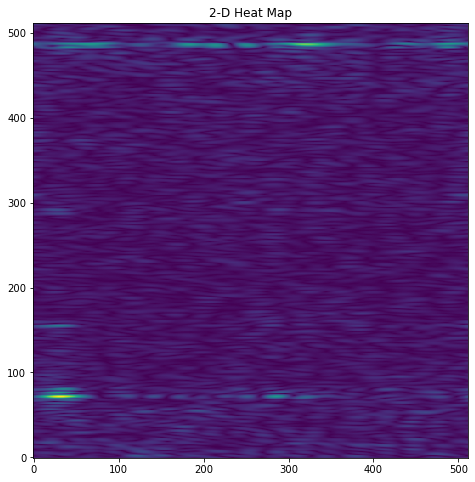

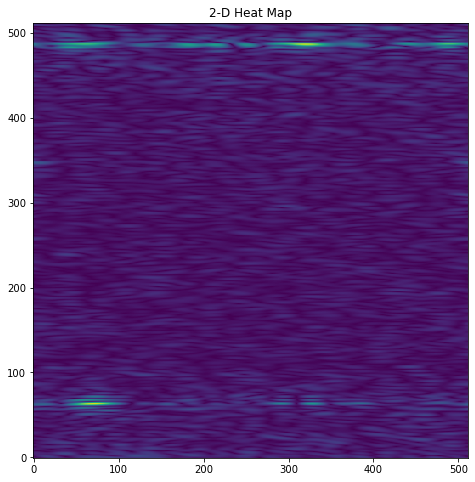

In [89]:
calArr = y_calArr
recArr = y_recArr

calFrame = np.mean(calArr,axis=0)
testFrame = (recArr - calFrame)[0,:,:]

Nfft = 512
testFrame_td = np.fft.ifft(testFrame,Nfft,1).reshape(20,20,-1)

testFrame = (recArr - calFrame)[0,:,:]
testFrame_td = np.fft.ifft(testFrame,Nfft,1).reshape(20,20,-1)
test = np.fft.fft(testFrame_td[0,:,:],Nfft,axis=0)

fig, ax = plt.subplots(figsize=(8,8))

# plt.figure(figsize=(20,8))  
ax.imshow(np.abs(test.T),origin='lower', interpolation='none')
  
ax.set_title( "2-D Heat Map" )


testFrame = (recArr - calFrame)[50,:,:]
testFrame_td = np.fft.ifft(testFrame,Nfft,1).reshape(20,20,-1)
test = np.fft.fft(testFrame_td[0,:,:],Nfft,axis=0)

fig, ax = plt.subplots(figsize=(8,8))

# plt.figure(figsize=(20,8))  
ax.imshow(np.abs(test.T),origin='lower', interpolation='none')
  
ax.set_title( "2-D Heat Map" )


### 6. Angle of Arrival (AoA) & Angle of Departure (AoD)

#### a. Parameter Setup

(-0.04, 0.04)

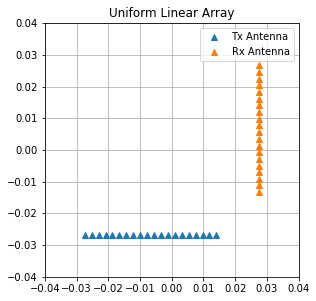

In [12]:
# Plot the Antenna Array
plt.figure(figsize=(10,10))
plt.subplot(121)
plt.plot(antsLocations[ 0:20,0],antsLocations[ 0:20,1],'^')
plt.plot(antsLocations[20:40,0],antsLocations[20:40,1],'^')
# plt.plot(np.mean(antsLocations[ 0:20,0]),np.mean(antsLocations[20:40,1]),'*')
plt.title('Uniform Linear Array')
plt.legend(['Tx Antenna','Rx Antenna'])
plt.grid()
plt.axis('scaled')
plt.xlim([-0.04,0.04])
plt.ylim([-0.04,0.04])

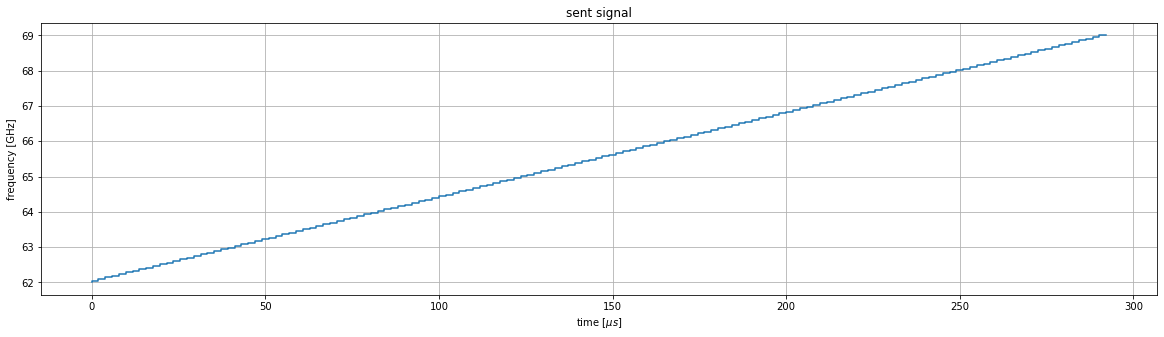

In [13]:
RBW = 1/(510e3) # 510 kHz
start_freq = freq[0]
stop_freq = freq[-1]
time = np.arange(0,N_freq) * RBW
plt.figure(figsize=(20,5))
plt.step(time*10**6,freq*10**-9)
plt.xlabel('time [$\mu s$]')
plt.ylabel('frequency [GHz]')
plt.title('sent signal')
plt.grid()
# plt.xlim((time*10**6)[0],(time*10**6)[-1])
# A = 1
# signal = A*np.sin(2*np.pi*freq*time)
# plt.figure(figsize=(20,5))
# plt.plot(time*10**6,signal)
# plt.xlabel('time [$\mu s$]')
# plt.ylabel('mganitude')

In [14]:
# parameter setup
n_rx = 20
n_tx = 20
n_sources = 5 # N
incident_angles= np.arange(0,181)

rx_array = antsLocations[20:40,1]
d_rx = np.linalg.norm(rx_array[1]-rx_array[0])

tx_array = antsLocations[0:20,0]
d_tx = np.linalg.norm(tx_array[1]-tx_array[0])

In [15]:
from collections import OrderedDict

def compute_steering_vectors(ant_array, thetas):
    M = np.size(ant_array, 0)  # Number of antennas   
    steering_vectors = np.zeros((M, np.size(thetas)), dtype=complex)
    for i in range(np.size(thetas)):    
        steering_vectors[:, i] = np.exp((ant_array-np.min(ant_array))*1j*2*np.pi*np.cos(np.radians(thetas[i]))) # Scanning vector      
        
    return steering_vectors

def corr_matrix(Y):
    """ Y: NxM (N: number of samples, M: number of antennas)"""
    R = Y @ (Y.conj().T)
    return R / Y.shape[0]

def compute_aoa_music(R, steering_vectors, signal_dimension): 
    aoa_spectrum = np.zeros(np.size(steering_vectors, 1),dtype=complex)
    M = np.size(R, 0)
    
    w, v = np.linalg.eig(R)
    print(w.shape)
    print(v.shape)
    # Sorting    
    # eig_dict = {}
    # for i in range(M):
    #     eig_dict[np.abs(w[i])] = v[:,i]
    # # print(eig_dict)
    # sorted_eig_dict = OrderedDict(sorted(eig_dict.items(), reverse=True))
    # eig_vec_matrix = np.array(list(sorted_eig_dict.values()))
    
    # # Generate noise subspace matrix
    # noise_dimension = M - signal_dimension    
    # U = eig_vec_matrix[:,-noise_dimension:]
    # U = np.matrix(U)
    # U_H = U.getH()    
    eig_array = []
    for i in range(M):
        eig_array.append([np.abs(w[i]),v[:,i]])
    eig_array = sorted(eig_array, key=lambda eig_array: eig_array[0], reverse=False)
    print(sorted(w))
    
    # Generate noise subspace matrix
    noise_dimension = M - signal_dimension    
    U = np.zeros((M,noise_dimension),dtype=complex)
    for i in range(noise_dimension):     
        U[:,i] = eig_array[i][1]     
        
    U = np.matrix(U)
    U_H = U.getH()
    
    theta_index=0
    for i in range(np.size(steering_vectors, 1)):             
        e = steering_vectors[:, i]
        e  = np.matrix(e).getT() 
        aoa_spectrum[theta_index] =  1/ (np.linalg.norm(U_H@e)**2)
        theta_index += 1
        
    return aoa_spectrum

In [16]:
# Array response vectors of the test signal
thetas = [30, 60 ,80]
N = 2**12
M = n_rx
a = np.exp(np.arange(0,M,1)*1j*2*np.pi*d_rx*np.cos(np.deg2rad(0)))
# print()
for theta in thetas:
    a += np.exp(np.arange(0,M,1)*1j*2*np.pi*d_rx*np.cos(np.deg2rad(theta)))

# Generate multichannel test signal 
soi = np.random.normal(0,1,N)  # Signal of Interest
soi_matrix  = np.outer( soi, a).T 

# Generate multichannel uncorrelated noise
noise = np.random.normal(0,np.sqrt(10**-1),(M,N))

# Create received signal array
rec_signal = soi_matrix + noise 
print(rec_signal.shape)
print(a)

(20, 4096)
[4.        +0.j         3.99982328+0.03350952j 3.99929313+0.06701496j
 3.99840964+0.10051221j 3.99717293+0.13399721j 3.99558317+0.16746586j
 3.99364057+0.20091408j 3.99134542+0.23433779j 3.98869803+0.26773291j
 3.98569877+0.30109538j 3.98234805+0.33442113j 3.97864636+0.3677061j
 3.97459419+0.40094623j 3.97019212+0.43413747j 3.96544076+0.46727579j
 3.96034078+0.50035714j 3.95489287+0.53337751j 3.94909781+0.56633288j
 3.9429564 +0.59921925j 3.9364695 +0.63203261j]


(20,)
(20, 20)
[(18.16759643148906-1.8303544863992126e-14j), (18.626554531440238+7.462834687017536e-14j), (18.86976319820421-6.26366664888947e-15j), (19.136820799838485+2.5124402167236458e-14j), (19.422989261739104-2.1032933408578796e-13j), (19.460837886897973+2.2177825430257056e-13j), (19.50312622698097-9.605443897980035e-14j), (19.988992856410434+4.083802410939935e-14j), (20.236272481892993-5.487303090062974e-14j), (20.337021098651828-1.2054484043140452e-13j), (20.589436622813402+5.0429800310761105e-14j), (20.86212594644962-7.720952145075247e-14j), (20.938058856949823-3.469971657955263e-14j), (21.430716631073008+4.375565618132001e-15j), (21.75489357628335+3.328870090759973e-14j), (21.879231161393026+1.012255437629469e-13j), (21.957154914950046-2.992907630932116e-14j), (22.248672695517406+1.4539623349357137e-13j), (22.73792189480167-1.473249400120068e-14j), (69015.20412049248+5.137082219979055e-13j)]
51


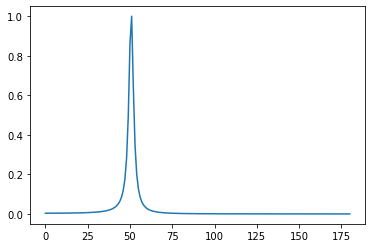

In [17]:
Y = rec_signal

rx_steering_vectors = compute_steering_vectors(rx_array, incident_angles)
R = corr_matrix(Y)
aoa = compute_aoa_music(R, rx_steering_vectors, signal_dimension = 4)
normalized_aoa = normalization(np.abs(aoa))#np.abs(aoa) / np.max(np.abs(aoa))
plt.plot(incident_angles, normalized_aoa);
print(incident_angles[np.argmax(normalized_aoa)])

(20,)
(20, 20)
[(1.9571684557864902e-05+5.425313233957165e-21j), (2.5010723500057105e-05-3.458744742398846e-21j), (2.722529753887124e-05-1.4750312650846915e-21j), (2.9998557890344503e-05-1.3393112444857503e-22j), (3.20446862609545e-05-2.5034062959448143e-21j), (3.760451297044836e-05-8.43548595369368e-21j), (3.933560954078373e-05+3.9577858795938074e-21j), (4.547931289192932e-05+2.8385949787947535e-21j), (4.599300245459462e-05-5.1652291098741414e-21j), (4.990513793428389e-05+6.172041883394696e-21j), (5.4892804261225064e-05+2.901936019628963e-21j), (6.103415507220197e-05+5.188339387791414e-21j), (6.897823617712078e-05-9.234759093037028e-21j), (7.059787071467685e-05+4.722181127232027e-21j), (8.433476075861521e-05+7.608862357764944e-21j), (9.323402734641324e-05-3.628992083770299e-21j), (0.00012016029183661873-2.4647846275475494e-21j), (0.0001515421412360309-4.8496427578606335e-21j), (0.00028856267632817366-8.934952807175676e-21j), (0.00046716642308140913-1.2988171359289591e-20j)]
(20,)
(20,

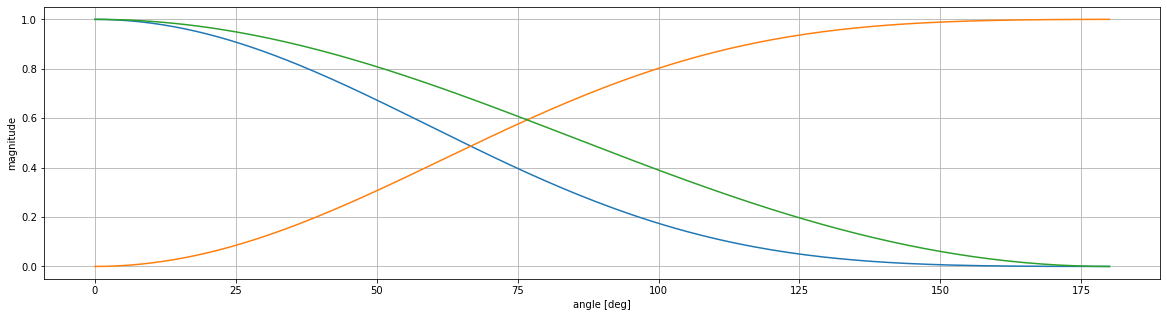

In [18]:
calArr = y_calArr
recArr = y_recArr
plt.figure(figsize=(20,5));
plt.grid();
plt.xlabel('angle [deg]');
plt.ylabel('magnitude');
# axes = plt.axes();
for i in [0, 50, 99]:
    Y = (recArr - np.mean(calArr, axis=0))[i,:,:]
    Y = Y.reshape(20,20,-1)[0,:,:]

    rx_steering_vectors = compute_steering_vectors(rx_array, incident_angles)
    R = corr_matrix(Y)
    aoa = compute_aoa_music(R, rx_steering_vectors, signal_dimension = 10)
    normalized_aoa = normalization(np.abs(aoa))#np.abs(aoa) / np.max(np.abs(aoa))
    plt.plot(incident_angles, normalized_aoa);

In [19]:
def sub2ind(array_shape, rows, cols):
    ind = rows*array_shape[1] + cols
    ind[ind < 0] = -1
    ind[ind >= array_shape[0]*array_shape[1]] = -1
    return ind

def ind2sub(array_shape, ind):
    ind[ind < 0] = -1
    ind[ind >= array_shape[0]*array_shape[1]] = -1
    rows = (ind.astype('int') / array_shape[1])
    cols = ind % array_shape[1]
    return (rows, cols)

def spatialSmooth2D(x,p,numRX):
    # sensor array
    L = x.shape[0]
    # p subarraySize
    # number of subarrays
    m=(L//numRX)-p+1
    for i in range(m):
        subarray = []
        for j in range(numRX):
            subarray.append(x[((j-1)*(L//numRX))+i:((j-1)*(L//numRX))+i+p-1,:])
        subarray = np.vstack(subarray)
        R = subarray @ subarray.conj().T
        if i == 0:
         Rtotal=R
        else:
            Rtotal=R+Rtotal

    R=Rtotal; #/size(x,2);
    return R

def sind(x):
    return np.sin(np.radians(x))

def calculateSteeringVec2D(d,AoA,slope,n,ts,c,carrier_freq,arraySize,antenna_dist):
    Z= np.exp(1j * ((2 * np.pi * slope* n.conj().T * 2*d * ts)/c))
    anglePhase = np.exp(1j * (2 * np.pi * antenna_dist *sind(AoA)*(carrier_freq/ c)))
    angledummy = np.matlib.repmat(anglePhase,arraySize/2,1)
    Z[arraySize/2+1:arraySize,:] = angledummy * Z[arraySize/2+1:arraySize,:]


    return Z.T

In [20]:
def music(SS,NN,indices_New,n,ind,dig_freq,AoA,res,endRange,slope,ts,c,carrier_freq,arraySize,antenna_dist,N):
    maxCorr = []
    if ind > 0:
        Ahat = []
        for x in np.arange(0,ind-1):
            indices = np.vstack(indices_New)[x,:]
            Ahat[:,x] = calculateSteeringVec2D
            perpAhat = np.eye(Ahat.shape[0] - Ahat@np.pinv(Ahat.conj().T@Ahat))@Ahat.conj().T
    else:
        Ahat = []
        PerpAhat = np.eye(NN.shape[0],dtype=type(2+1j))
    NN = PerpAhat@NN
    Ps = (NN@NN.conj().T)

    SSp=PerpAhat*SS
    PsA = Ps*SSp
    music_spec_num = np.sum((SSp.conj().T)*(PsA.T),1)
    music_spec_den = np.sum((SSp.conj().T)*(SSp.T),1)
    PP = np.abs(music_spec_num/music_spec_den)

    maxCorr,loopVarMax = max(PP)
    ToF_idx,AoA_idx = ind2sub(np.array([dig_freq.shape[1], AoA.shape[1]]),loopVarMax)
    indices= np.array([AoA(AoA_idx), dig_freq(ToF_idx), maxCorr])
    
    n = np.arange(0,N)
    Ahat=calculateSteeringVec2D(indices[:,1],indices[:,0],slope,n,ts,c,carrier_freq,arraySize,antenna_dist)
    return indices, Ahat

def music_2D(Y, K, res, ts, slope, carrier_freq, antenna_dist, numRX):
    L = Y.shape[1]
    N = Y.shape[0]
    endRange = time_vec[-1]
    angleSpacing = 1
    tauSpacing = res
    ranges = np.array([[-40, 40],
                       [  0, endRange]])
    AoA = np.arange(ranges[0,0],ranges[0,1],angleSpacing)
    ToF = np.arange(ranges[1,0],ranges[1,1],tauSpacing)
    GridPts = [ToF.shape[0], AoA.shape[0]]
    [ToFind,AoAind] = ind2sub(GridPts,np.arange(1,np.prod(GridPts)))

    zt = ranges[1,0] + (ToFind-1)*tauSpacing
    qt = ranges[0,0] + (AoAind-1)*angleSpacing

    ppp=np.vstack([[qt[:].conj().T], [zt[:].conj().T]])

    R = spatialSmooth2D(Y,round((N/numRX)/2),numRX)
    arraySize= R.shape[0]

    n = np.arange(0,(arraySize/2)-1)
    n = np.vstack([n,n])
    print(n.T.shape)
    print(ppp[1,:].shape)
    Z = np.exp(1j * ((2 * np.pi * slope* n.conj().T @ 2*ppp[1,:] * ts)/c))
    anglePhase = np.exp(1j * (2 * np.pi * antenna_dist * sind(ppp[0,:])*(carrier_freq/ c)))
    angledummy = np.matlib.repmat(anglePhase,arraySize/2,1)
    Z[arraySize/2+1:arraySize,:] = angledummy * Z[arraySize/2+1:arraySize,:]

    Q, D = np.linalg.eig(R)
    D, I = np.sort(np.diag(D))
    I = np.flipud(I)
    Q = Q[:, I]
    Q = Q[:, 1:K]

    indices_New=[]
    Ahat_New = []
    for ind in range(K):
        indices, Ahat = music(Z,Q,indices_New,n,ind,ToF,AoA,res,endRange,slope,ts,c,carrier_freq,arraySize,antenna_dist,N)
        indices_New.append(indices)
        Ahat_New.append(Ahat)

    indices_New = np.vstack(indices_New)
    Ahat_New = np.hstack(Ahat_New)

    return indices_New, Ahat_New

In [21]:
Y = recArr[0,:,:]-np.mean(calArr,axis=0)
Y = Y.reshape(20,20,150)[0,:,:]
K = 5
slope = (freq[1]-freq[0])/RBW
res = np.linalg.norm(time_vec[1]-time_vec[0])
indices_New, Ahat_New = music_2D(Y, K, res, RBW, slope, freq, d_rx, n_rx)

(9, 2)
(40879,)


ValueError: matmul: Input operand 1 does not have enough dimensions (has 0, gufunc core with signature (n?,k),(k,m?)->(n?,m?) requires 1)

(20,)


In [ ]:
# parameter setup
n_rx = 20
n_tx = 20
n_sources = 5 # N
d_rx = np.linalg.norm(antsLocations[20,:]-antsLocations[21,:])
d_tx = np.linalg.norm(antsLocations[0,:]-antsLocations[1,:])
rx_array_alignment = antsLocations[20:40,1]
tx_array_alignment = antsLocations[0:20,0]
incident_angles= np.linspace(-90,90,180)
rx_ula_scanning_vectors = gen_ula_scanning_vectors(rx_array_alignment, incident_angles)
print(rx_ula_scanning_vectors)
tx_ula_scanning_vectors = gen_ula_scanning_vectors(tx_array_alignment, incident_angles)

[[1.        -5.11696405e-18j 0.99999892-1.46658048e-03j
  0.9999957 -2.93270606e-03j ... 0.9999957 -2.93270606e-03j
  0.99999892-1.46658048e-03j 1.        -5.11696405e-18j]
 [1.        -4.30902235e-18j 0.99999924-1.23501527e-03j
  0.99999695-2.46964824e-03j ... 0.99999695-2.46964824e-03j
  0.99999924-1.23501527e-03j 1.        -4.30902235e-18j]
 [1.        -3.50108066e-18j 0.9999995 -1.00344999e-03j
  0.99999799-2.00658989e-03j ... 0.99999799-2.00658989e-03j
  0.9999995 -1.00344999e-03j 1.        -3.50108066e-18j]
 ...
 [1.        +8.65651812e-18j 0.99999692+2.48105554e-03j
  0.99998769+4.96133160e-03j ... 0.99998769+4.96133160e-03j
  0.99999692+2.48105554e-03j 1.        +8.65651812e-18j]
 [1.        +9.46445981e-18j 0.99999632+2.71262018e-03j
  0.99998529+5.42438486e-03j ... 0.99998529+5.42438486e-03j
  0.99999632+2.71262018e-03j 1.        +9.46445981e-18j]
 [1.        +1.02724015e-17j 0.99999567+2.94418467e-03j
  0.99998267+5.88743697e-03j ... 0.99998267+5.88743697e-03j
  0.99999567+2

In [ ]:
def DOA_MUSIC(R, scanning_vectors, signal_dimension, angle_resolution = 1):
    """                                 
                    MUSIC - Multiple Signal Classification method
        
        
        Description:
         ------------    
           The function implements the MUSIC method for direction estimation
           
           Calculation method : 
                                                    1
                        ADORT(theta) = ---------------------------
                                             H        H 
                                      S(theta) * En En  * S(theta)
         Parameters:
        -----------                
            :param R: spatial correlation matrix            
            :param scanning_vectors : Generated using the array alignment and the incident angles                                                 
            :param signal_dimension:  Number of signal sources    
                       
            :type R: 2D numpy array with size of M x M, where M is the number of antennas in the antenna system                            
            :tpye scanning vectors: 2D numpy array with size: M x P, where P is the number of incident angles                                   
            :type signal_dimension: int
            
       Return values:
       --------------
       
            :return  ADORT : Angular dependent orthogonality. Expresses the orthongonality of the current steering vector to the 
                    noise subspace
            :rtype : numpy array
         
            :return -1, -1: Input spatial correlation matrix is not quadratic
            :return -2, -2: dimension of R not equal with dimension of the antenna array 
            :return -3, -3: Spatial correlation matrix is singular
    """
    # --- Parameters ---  
    
    # --> Input check
    if np.size(R, 0) != np.size(R, 1):
        print("ERROR: Correlation matrix is not quadratic")
        return -1, -1
    
    if np.size(R, 0) != np.size(scanning_vectors, 0):
        print("ERROR: Correlation matrix dimension does not match with the antenna array dimension")
        return -2, -2                    
    
    ADORT = np.zeros(np.size(scanning_vectors, 1),dtype=complex)
    M = np.size(R, 0)
    
    # --- Calculation ---
    # Determine eigenvectors and eigenvalues
    sigmai, vi = lin.eig(R)
    sigmai, vi = np.linalg.eig(R)
    print(np.abs(vi))
    # Sorting    
    eig_array = []
    for i in range(M):
        eig_array.append([np.abs(sigmai[i]),vi[:,i]])
    eig_array = sorted(eig_array, key=lambda eig_array: eig_array[0], reverse=False)
    
    # Generate noise subspace matrix
    noise_dimension = M - signal_dimension    
    E = np.zeros((M,noise_dimension),dtype=complex)
    for i in range(noise_dimension):     
        E[:,i] = eig_array[i][1]     
        
    E = np.matrix(E)    
    
    theta_index=0
    for i in range(np.size(scanning_vectors, 1)):             
        S_theta_ = scanning_vectors[:, i]
        S_theta_  = np.matrix(S_theta_).getT() 
        ADORT[theta_index]=  1/np.abs(S_theta_.getH()*(E*E.getH())*S_theta_)
        theta_index += 1
         
    return ADORT

def DOA_plot(DOA_data, incident_angles, log_scale_min=None, alias_highlight=True, d=0.5, axes=None):
    
    DOA_data = np.divide(np.abs(DOA_data),np.max(np.abs(DOA_data))) # normalization
    if(log_scale_min != None):        
        DOA_data = 10*np.log10(DOA_data)                
        theta_index = 0        
        for theta in incident_angles:                    
            if DOA_data[theta_index] < log_scale_min:
                DOA_data[theta_index] = log_scale_min
            theta_index += 1                     
        
    if axes is None:
        fig = plt.figure()
        axes  = fig.add_subplot(111)
    
    #Plot DOA results  
    axes.plot(incident_angles,DOA_data)    
    axes.set_title('Angle of Arrival estimation ',fontsize = 16)
    axes.set_xlabel('Incident angle [deg]')
    axes.set_ylabel('Amplitude [dB]')   

    # Alias highlight
    if alias_highlight:
        (theta_alias_min,theta_alias_max) = alias_border_calc(d)        
        print('Minimum alias angle %2.2f '%theta_alias_min)
        print('Maximum alias angle %2.2f '%theta_alias_max)
    	
        axes.axvspan(theta_alias_min, theta_alias_max, color='red', alpha=0.3) 
        axes.axvspan(180-theta_alias_min, 180, color='red', alpha=0.3) 
        
        axes.axvspan(180-theta_alias_min, 180-theta_alias_max, color='blue', alpha=0.3) 
        axes.axvspan(0, theta_alias_min, color='blue', alpha=0.3) 

    plt.grid()   
    return axes

def get_angle(X):
    # Estimating the spatial correlation matrix
    R = corr_matrix_estimate(X.T, imp="fast")

    array_alignment = np.arange(0, M, 1) * d
    incident_angles = np.arange(-90, 91, 1)
    scanning_vectors = np.zeros((M, np.size(incident_angles)), dtype=complex)
    for i in range(np.size(incident_angles)):
        scanning_vectors[:, i] = np.exp(
            array_alignment * 1j * 2 * np.pi * np.sin(np.radians(incident_angles[i])) / wavelength)  # scanning vector

    ula_scanning_vectors = scanning_vectors

    # Estimate DOA
    MUSIC = DOA_MUSIC(R, ula_scanning_vectors, signal_dimension=1)
    norm_data = np.divide(np.abs(MUSIC), np.max(np.abs(MUSIC)))
    return float(incident_angles[np.where(norm_data == 1)[0]][0])

def get_coordinate(azimuth, elevation, height, receiver_coords):
    nx = np.cos(np.deg2rad(90.0 - azimuth))
    nz = np.cos(np.deg2rad(90.0 - abs(elevation)))
    if math.isclose(nx, 0.0, abs_tol=1e-16) or math.isclose(nz, 0.0, abs_tol=1e-16):
        return [float("nan"),  float("nan")]
    else:
        ny = np.sqrt(1 - nx ** 2 - nz ** 2)
        t = (height - receiver_coords[2]) / nz
        x = receiver_coords[0] + t * nx
        y = receiver_coords[1] - t * ny
    return [x, y]

SIGMA_FILTER_WINDOW = 5
# 68–95–99.7 rule for identify and discard positional outliers 
class SigmaFilter:
    def __init__(self, maxlen = SIGMA_FILTER_WINDOW):
        self.deque = deque(maxlen = maxlen)

    def isValid(self, v):
        isValid = False
        if len(self.deque) == SIGMA_FILTER_WINDOW:
            mean_v, std_v = np.array(self.deque).mean(axis=0), np.array(self.deque).std(axis=0)
            if distance.euclidean(v, mean_v) < distance.euclidean(mean_v + 3 * std_v, mean_v):
                isValid = True
            else:
                print('outlier:', v)

        self.deque.append(v)
        return isValid

def to_plus_minus_pi(angle):
    while angle >= 180:
        angle -= 2 * 180
    while angle < -180:
        angle += 2 * 180
    return angle

In [ ]:
# generate test signal
theta = 60
M = n_rx
N = n_sources

# Array response vectors of the test signal
a = np.exp(np.arange(0,M,1)*1j*2*np.pi*d_rx*np.cos(np.deg2rad(theta)))

# Generate multichannel test signal 
soi = np.random.normal(0,1,N)  # Signal of Interest
soi_matrix  = np.outer( soi, a).T 

# Generate multichannel uncorrelated noise
noise = np.random.normal(0,np.sqrt(10**-1),(M,N))

# Create received signal array
rec_signal = soi_matrix + noise 

#### b. Angle of Arrival (AoA): y direction

In [ ]:
calArr = y_calArr
recArr = y_recArr

rec_signal = (recArr[0,:,:]-np.mean(calArr,axis=0))
rec_signal = rec_signal.reshape(20,20,-1)[10,:,:]



[[ 2.35422747e-05+0.00000000e+00j  2.46041397e-06-1.30396405e-05j
   1.51170351e-06-9.34682642e-06j -4.29094493e-06-1.10567507e-05j
  -3.33331199e-06-1.33353397e-05j -3.63216954e-06-4.62491212e-06j
  -7.23076258e-06-1.14844823e-05j -1.13347130e-05+5.96824157e-06j
  -1.32300034e-05-1.42243287e-06j -9.05160514e-06+1.21637045e-05j
  -7.27323973e-06+1.27374707e-05j -4.10991471e-06+1.17994221e-05j
   1.02520233e-06+1.30180297e-05j -2.71460535e-06+5.66974193e-06j
  -5.17418841e-06+3.87197045e-06j  5.22752195e-07-5.39518600e-06j
   7.93935705e-07+1.72331827e-06j -1.59741365e-06-3.31780610e-06j
   4.95255086e-06-4.38091514e-07j -2.04287881e-06+2.81159037e-07j]
 [ 2.46041397e-06+1.30396405e-05j  3.46951613e-05+0.00000000e+00j
   1.32891058e-05-2.83794177e-06j  1.66468165e-05-1.04359725e-05j
   1.63245676e-05-5.40157765e-06j  9.42836013e-06-1.06412703e-05j
   1.26943140e-05-1.61913141e-05j -1.50534791e-05-1.56662956e-05j
  -3.38774793e-06-2.11612974e-05j -2.41055595e-05-1.19042888e-05j
  -2.6865

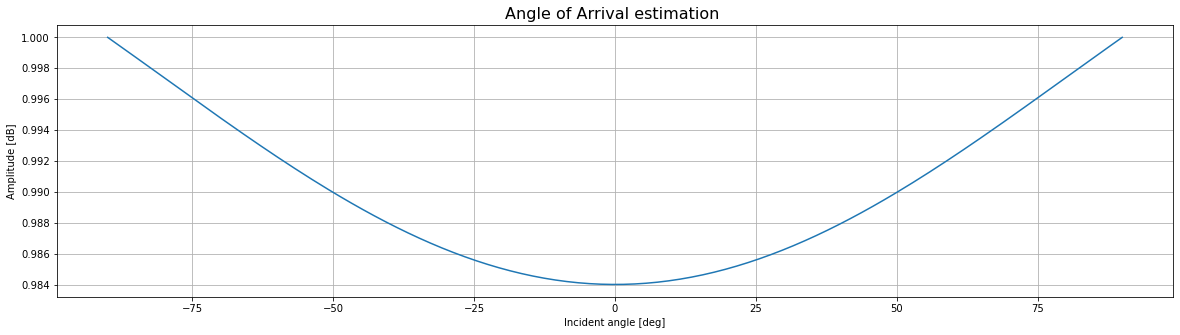

In [ ]:
calArr = y_calArr
recArr = y_recArr

rec_signal = (recArr[0,:,:]-np.mean(calArr,axis=0))
rec_signal = rec_signal.reshape(20,20,-1)[10,:,:]
R = corr_matrix_estimate(rec_signal.T, imp="mem_eff")
# R = np.real(R)
print(R)
MUSIC = DOA_MUSIC(R, rx_ula_scanning_vectors, signal_dimension = 5)

plt.figure(figsize=(20,5))
axes = plt.axes();
DOA_plot(MUSIC, incident_angles, axes=axes, alias_highlight=False);

In [ ]:
N_SAMPLES_OF_REF_PERIOD = 1
# map parameters
width_map = 14.7
height_map = 12.4
kx_locator = 0.532471
ky_locator = 0.558504
x_locator = kx_locator * width_map
y_locator = ky_locator * height_map
z_locator = 0.2
z_beacon = 0.814



velSigmaFilter = SigmaFilter(SIGMA_FILTER_WINDOW)
x_00, azimuth_x_12, elevation_x_12 = [], [], []
azimuth_phases, elevation_phases = [], []
for i in messages:
    ref_phases = []
    iq_samples = [i['aoa']['iq'][n:n + 2] for n in range(0, len(i['aoa']['iq']), 2)]

    for iq_idx in range(N_SAMPLES_OF_REF_PERIOD - 1):
        iq_next = complex(iq_samples[iq_idx + 1][0], iq_samples[iq_idx + 1][1])
        iq_cur = complex(iq_samples[iq_idx][0], iq_samples[iq_idx][1])
        phase_next = np.rad2deg(np.arctan2(iq_next.imag, iq_next.real))
        phase_cur = np.rad2deg(np.arctan2(iq_cur.imag, iq_cur.real))
        ref_phases.append((to_plus_minus_pi(phase_next - phase_cur)))
    phase_ref = np.mean(ref_phases)

    iq_2ant_batches = [iq_samples[n:n + 2] for n in range(N_SAMPLES_OF_REF_PERIOD, len(iq_samples), 2)]
    for iq_batch_idx, iq_batch in enumerate(iq_2ant_batches[:-1]):
        iq_next = complex(iq_batch[1][0], iq_batch[1][1])
        iq_cur = complex(iq_batch[0][0], iq_batch[0][1])
        phase_next = np.rad2deg(np.arctan2(iq_next.imag, iq_next.real))
        phase_cur = np.rad2deg(np.arctan2(iq_cur.imag, iq_cur.real))
        diff_phase = to_plus_minus_pi((phase_next - phase_cur) - 2 * phase_ref)
        if iq_batch_idx % 2 != 0:
            elevation_phases.append(diff_phase)
        else:
            x_00.append(1)
            azimuth_phases.append(diff_phase)
messages.clear()
# MUSIC algo
X = np.zeros((M, np.size(x_00)), dtype=complex)
X[0, :] = x_00
for i in azimuth_phases:
    azimuth_x_12.append(np.exp(1j * np.deg2rad(i)))
X[1, :] = azimuth_x_12
azimuth_angle = get_angle(X)

for i in elevation_phases:
    elevation_x_12.append(np.exp(1j * np.deg2rad(i)))
X[1, :] = elevation_x_12
elevation_angle = get_angle(X)
print(f'azimuth_angle:{azimuth_angle}, elevation_angle:{elevation_angle}')

xy = get_coordinate(azimuth_angle, elevation_angle, z_beacon, [x_locator, y_locator, z_locator])
if not math.isnan(xy[0]) and not math.isnan(xy[1]):
    if velSigmaFilter.isValid(xy):
        print(f'x_beacon:{xy[0]}, y_beacon:{xy[1]}')

NameError: name 'messages' is not defined

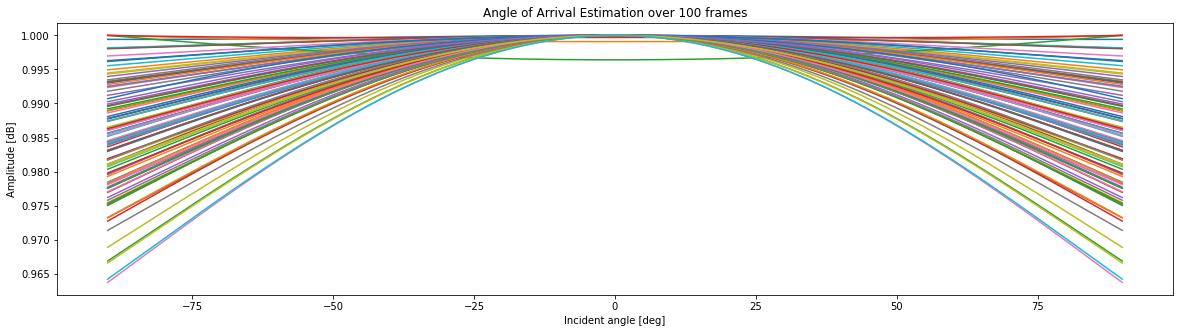

In [ ]:
plt.figure(figsize=(20,5))
axes = plt.axes()
legends = []
aoa = []
for i in range(100):
    # for j in range(20):
    rec_signal = (recArr[i,:,:]-np.mean(calArr,axis=0)).reshape(20,20,-1)[10,:,:]
    R = corr_matrix_estimate(rec_signal.T, imp="mem_eff")
    MUSIC = DOA_MUSIC(R, rx_ula_scanning_vectors, signal_dimension = 2)
    DOA_plot(MUSIC, incident_angles, axes=axes, alias_highlight=False);
    DOA_data = np.divide(np.abs(MUSIC),np.max(np.abs(MUSIC))) # normalization
    aoa.append(np.argmax(DOA_data))
    legends.append(f'frame: {i}')
plt.title('Angle of Arrival Estimation over 100 frames')
# plt.legend(legends)
aoa_out = np.deg2rad(incident_angles[aoa])

In [ ]:
rx_locs = antsLocations[20:40,0:2]
angle_list = incident_angles * np.pi / 180
# Find Borderlines
MinX = 5
MinY = 5
MaxX = -5
MaxY = -5
for loc in rx_locs:
    MinX = min(MinX, loc[0])
    MinY = min(MinY, loc[1])
    MaxX = max(MaxX, loc[0])
    MaxY = max(MaxY, loc[1])

x_range = np.linspace(MinX,MaxX,100)
y_range = np.linspace(MinY,MaxY,100)

position_likelihood = {}
for x in x_range:
    for y in y_range:
        likelihood = 1
        for i,array in enumerate(rx_locs):
            if x == array[0] and y == array[1]:
                likelihood = 0
            else:
                cur_theta = np.arctan2((y-array[1]),(x-array[0]))
                cur_theta = angle_list[np.argmin(np.abs(angle_list - cur_theta))]
                likelihood = likelihood * aoa_spectrums[i][cur_theta]
        position_likelihood[(x,y)] = likelihood

userLoc = max(position_likelihood, key=position_likelihood.get)

#### c. Angle of Departure (AoD): x direction

Text(0.5, 1.0, 'Angle of Departure Estimation')

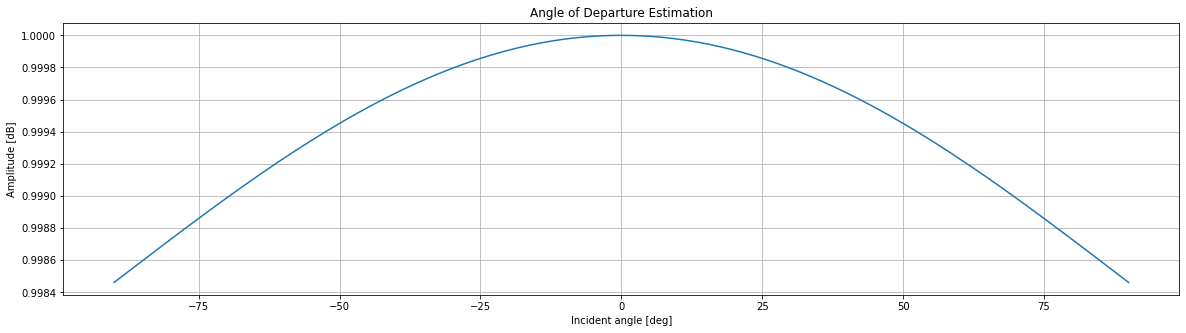

In [ ]:
calArr = z_calArr
recArr = z_recArr
rec_signal = (recArr[0,:,:]-np.mean(calArr,axis=0)).reshape(20,20,-1)[:,10,:]
R = corr_matrix_estimate(rec_signal.T, imp="mem_eff")
MUSIC = DOA_MUSIC(R, tx_ula_scanning_vectors, signal_dimension = 2)
plt.figure(figsize=(20,5))
axes = plt.axes();
DOA_plot(MUSIC, incident_angles, axes=axes, alias_highlight=False);
plt.title('Angle of Departure Estimation')


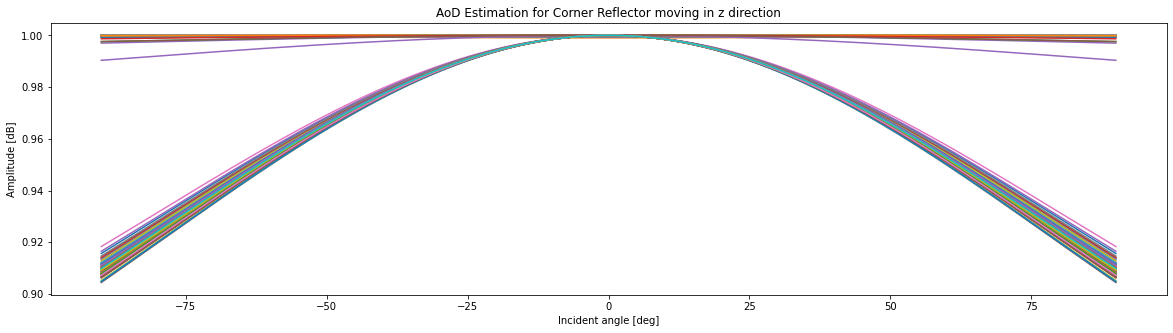

In [ ]:
plt.figure(figsize=(20,5))
axes = plt.axes()
aod = []
for i in range(100):
    # for j in range(20):
    rec_signal = (recArr[i,:,:]-np.mean(calArr,axis=0)).reshape(20,20,-1)[:,10,:]
    R = corr_matrix_estimate(rec_signal.T, imp="mem_eff")
    MUSIC = DOA_MUSIC(R, tx_ula_scanning_vectors, signal_dimension = 1)
    DOA_data = np.divide(np.abs(MUSIC),np.max(np.abs(MUSIC))) # normalization
    aod.append(np.argmax(DOA_data))
    DOA_plot(MUSIC, incident_angles, axes=axes, alias_highlight=False);
plt.title('AoD Estimation for Corner Reflector moving in z direction')
aod_out = np.deg2rad(incident_angles[aod])

#### d. 3D Point Cloud

(3, 100)


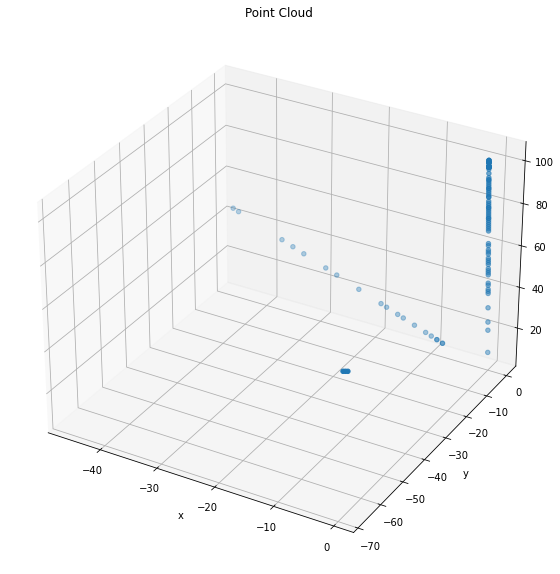

In [ ]:
center_point = [np.mean(tx_array_alignment),np.mean(rx_array_alignment),0]
z_length = np.array(z_locations)
points = np.array(center_point + np.array([z_length*np.sin(aod_out),z_length*np.sin(aoa_out),z_length]).T).T
print(points.shape)

# define grid
xgrid = np.arange(-1.5, 1.5+0.025, 0.0215)
ygrid = np.arange(-1.5, 1.5+0.025, 0.0215)
zgrid = np.arange( 0.0, 3+0.025,   0.0215)

[Xgrid,Ygrid,Zgrid] = np.meshgrid(xgrid,ygrid,zgrid)
th = 1

plt.ion()
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')   
# ax.scatter(Xgrid[],Ygrid[Xgrid==center_point[1]],Zgrid)
ax.scatter(*points)
# ax.view_init(0, 0)
ax.set_title('Point Cloud')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_label('z')
ax.set_aspect('auto')